<a href="https://colab.research.google.com/github/githubforkj/signate/blob/main/25beginner/25beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 今回の目的


**優先順**
1. パイプラインを使えるようになる
2. カテゴリカル変数の前処理が出来るようになる
3. 実験管理が出来るようになる
4. gridsearch,アンサンブルなどを扱えるようになる(できれば)

*期限が来たので、諦めました。。。。。*


# 実装


### 初期設定


In [ ]:
# signateとの連携

!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

In [2]:
# コンペのデータをダウンロード
!signate download --competition-id={741}

submit_sample.csv

test.csv

train.csv


Download completed.


In [12]:
'''
    import module
'''

# Importing Classifier Modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# Cross Validation(k-fold)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Pipeline and GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skm 

# Make
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder



In [3]:
import pandas as pd

test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')

In [ ]:
# 相関行列の作成
from sklearn import datasets

corr = train.corr()
print(corr)

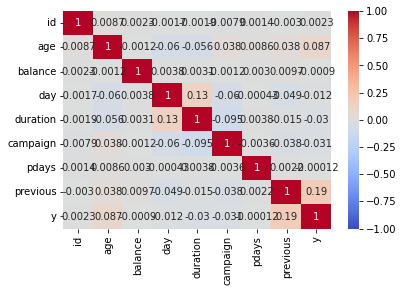

In [5]:
# ヒートマップで表示
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

## 前処理


In [13]:
# カテゴリカル変数をlabel encodingした結果、age, marital, education, previous, poutcomeが関係ありそうだったので、専用のindexを作成する

n_train = pd.DataFrame()
n_test = pd.DataFrame()
n_train[['age','marital','education','previous','poutcome','y']] = train[['age','marital','education','previous','poutcome','y']]
n_test[['age','marital','education','previous','poutcome']] = test[['age','marital','education','previous','poutcome']]

In [7]:
n_train.head()

,age,marital,education,previous,poutcome,y
0,31,married,secondary,0,other,0
1,29,single,tertiary,0,unknown,1
2,35,married,tertiary,0,failure,0
3,31,married,secondary,0,failure,0
4,48,married,primary,0,unknown,0


In [9]:
# pandasを使用するとこれでone-hotエンコーディングできる
pd.get_dummies(n_train)

,age,previous,y,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,31,0,0,0,1,0,0,1,0,0,0,1,0,0
1,29,0,1,0,0,1,0,0,1,0,0,0,0,1
2,35,0,0,0,1,0,0,0,1,0,1,0,0,0
3,31,0,0,0,1,0,0,1,0,0,1,0,0,0
4,48,0,0,0,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,37,0,0,0,1,0,0,1,0,0,0,0,0,1
27096,35,0,0,0,1,0,0,1,0,0,0,0,0,1
27097,35,0,0,0,1,0,0,0,0,1,0,0,0,1
27098,30,0,0,0,0,1,0,1,0,0,0,0,0,1


### カテゴリカル変数にラベルエンコーディング


[video turorial](https://www.youtube.com/watch?v=irHhDMbw3xo)

In [ ]:
# カテゴリカル変数のエンコーディングを行う
    # 元の変数と数値の対応を詳細に把握してはいないが、ぶち込めば何とかなるであろう。。
from sklearn.preprocessing import OrdinalEncoder

train_oe = train.copy()
oe = OrdinalEncoder()
train_oe[['job',
          'marital',
          'education',
          'default',
          'housing',
          'loan',
          'contact',
          'month',
          'poutcome']] = oe.fit_transform(train[['job',
                                                    'marital', 
                                                    'education',
                                                    'default',
                                                    'housing',
                                                    'loan', 
                                                    'contact',
                                                    'month',
                                                    'poutcome']])
train_oe.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,7.0,1.0,1.0,0.0,12294,1.0,0.0,0.0,21,8.0,101,3,498,0,1.0,0
1,1,29,2.0,2.0,2.0,0.0,43027,0.0,0.0,0.0,22,1.0,158,2,702,0,3.0,1
2,2,35,4.0,1.0,2.0,0.0,12252,1.0,0.0,0.0,11,8.0,351,1,826,0,0.0,0
3,3,31,9.0,1.0,1.0,0.0,99121,1.0,1.0,2.0,16,7.0,658,2,120,0,0.0,0
4,4,48,10.0,1.0,0.0,0.0,42005,1.0,0.0,1.0,3,0.0,177,1,273,0,3.0,0


In [ ]:
# testも
test_oe = test.copy()
oe = OrdinalEncoder()
test_oe[['job',
          'marital',
          'education',
          'default',
          'housing',
          'loan',
          'contact',
          'month',
          'poutcome']] = oe.fit_transform(test[['job',
                                                    'marital', 
                                                    'education',
                                                    'default',
                                                    'housing',
                                                    'loan', 
                                                    'contact',
                                                    'month',
                                                    'poutcome']])
test_oe.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,9.0,2.0,1.0,0.0,89043,0.0,0.0,0.0,7,2.0,101,2,184,2,2.0
1,1,37,7.0,1.0,1.0,0.0,64372,1.0,0.0,0.0,7,4.0,158,3,241,0,3.0
2,2,31,7.0,2.0,1.0,0.0,31606,1.0,0.0,2.0,15,7.0,152,2,47,0,3.0
3,3,31,0.0,1.0,1.0,0.0,94826,1.0,0.0,0.0,27,7.0,345,2,490,0,3.0
4,4,32,7.0,1.0,1.0,0.0,100401,0.0,0.0,0.0,7,3.0,126,1,686,0,1.0


### Make Pipeline


## Cross validation 

In [ ]:
n_train['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [ ]:
n_train.shape

(27100, 6)

In [ ]:
# 試しに'previous'列をxに指定してみる
X = n_train.loc[:,['previous']]
y = n_train.loc[:,['y']]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(solver='lbfgs')

## one-hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)

In [ ]:
ohe.fit_transform(train[['previous']])

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [ ]:
ohe.categories_

[array([0, 1, 2, 3])]

In [ ]:
X = n_train.drop('y', axis='columns')

In [ ]:
from sklearn.compose import make_column_transformer

In [ ]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['age','marital','education','previous','poutcome']),
    remainder='passthrough'
)

In [ ]:
column_trans.fit_transform(X)

<27100x57 sparse matrix of type '<class 'numpy.float64'>'
	with 135500 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
pipe = make_pipeline(column_trans, logreg)

In [ ]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['age', 'marital',
                                                   'education', 'previous',
                                                   'poutcome'])])),
                ('logisticregression', LogisticRegression())])

In [ ]:
cross_val_score(pipe, X, y, cv=5, scoring = 'accuracy').mean()

In [ ]:
pipe.fit(X,y)

In [ ]:
pipe.predict(X)

In [ ]:
pipe.score(X,y)

0.9289667896678967

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe,
                         X,
                         y,
                         cv=5,
                         scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback 

In [ ]:
scores

array([       nan, 0.92878229, 0.9297048 ,        nan,        nan])

In [ ]:
y.value_counts(normalize=True)

y
0    0.922066
1    0.077934
dtype: float64

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(logreg,X,y,cv=5, scoring='accuracy').mean()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.9211070110701106